<font size="200">Yelp Reviews and NLP</font>

### Gabriel So

## Overview

- Review forum
- Restaurants and businesses
- 150 million reviews as of 2017
- 5-star ratings system
- Check-in

### Yelp Open Dataset
- Open Dataset of over 5 million reviews
- Subset of Yelp's full database
- Over 1 million users
- English language
- 17th release of this dataset

## Data at a Glance

In [ ]:
bid_stars = pd.read_sql(""" SELECT business_id, user_id, text, stars FROM review""", engine)

useful = pd.read_sql(""" SELECT useful FROM review""", engine)

from sklearn.model_selection import train_test_split
subX, bigX, suby, bigy = train_test_split(bid_stars['text'], bid_stars['stars'], train_size = 0.1)

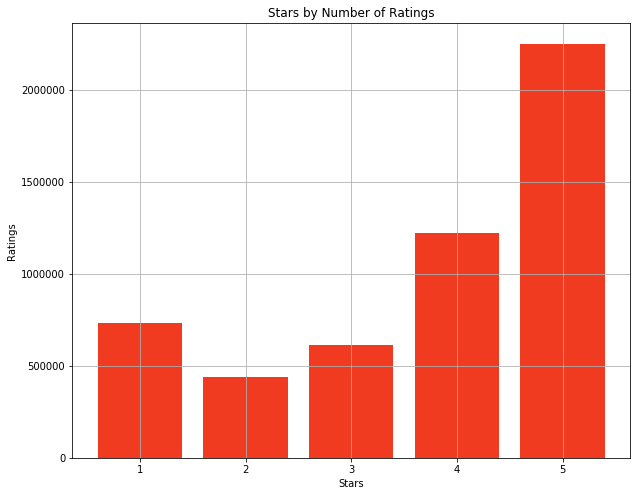

In [53]:
plt.bar(bid_stars['stars'].value_counts().index,bid_stars['stars'].value_counts(), color = '#f03b20')
plt.xlabel('Stars')
plt.ylabel('Ratings')
plt.title('Stars by Number of Ratings')
plt.grid()
plt.show();

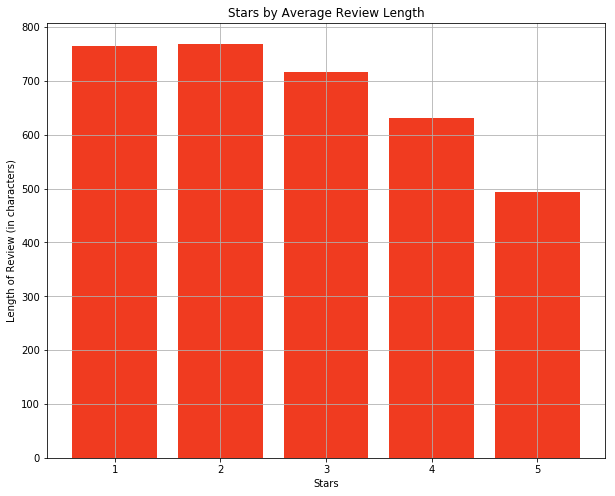

In [52]:
plt.bar(mean_len_star.index,mean_len_star['length(text)'], color = '#f03b20')
plt.xlabel('Stars')
plt.ylabel('Length of Review (in characters)')
plt.title('Stars by Average Review Length')
plt.grid()
plt.show();

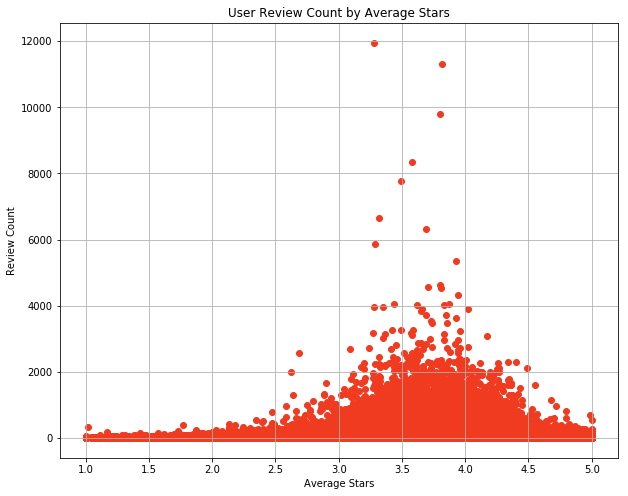

In [51]:
plt.scatter(users['average_stars'],users['review_count'], color = '#f03b20')
plt.xlabel('Average Stars')
plt.ylabel('Review Count')
plt.title('User Review Count by Average Stars')
plt.grid()
plt.show();

The most active users are around the 3.5-4 range

# Modelling the Data

### Parts of Speech Tagging

- First abstract parts of speech from reviews counting each occurrence
- Use category counts
- More generalizable across languages
- More interpretable results

In [14]:
import nltk

In [76]:
subX2 = subX.reset_index()
suby2 = suby.reset_index()

tokened = nltk.pos_tag(nltk.word_tokenize(subX2['text'][0]))

pos_count = []
for i in range(len(subX2['text'])):
    tokened = nltk.pos_tag(nltk.word_tokenize(subX2['text'][i]))
    tags = [b[1] for b in tokened]
    fd = nltk.FreqDist(tags)
    pos_count.append(dict(fd))
    if i%5000==0:
        print(f'done {i}')

tagged = pd.DataFrame(pos_count)
tagged = tagged.drop(columns=['#', '$', '\'\'', '(', ')', ',', '.', ':','``'])
tagged = tagged.fillna(0)


In [218]:
tagged.head()

CC   CD    DT   EX   FW    IN    JJ  JJR  JJS   LS ...    VB   VBD  VBG  \
0   8.0  5.0  25.0  0.0  0.0  28.0  12.0  0.0  3.0  0.0 ...   5.0  14.0  6.0   
1  10.0  1.0  39.0  1.0  0.0  45.0  24.0  2.0  0.0  0.0 ...   6.0  21.0  7.0   
2   1.0  0.0   1.0  0.0  0.0   1.0   4.0  0.0  0.0  0.0 ...   0.0   0.0  0.0   
3   7.0  2.0  13.0  1.0  0.0  10.0  12.0  0.0  0.0  0.0 ...   7.0   1.0  1.0   
4   4.0  2.0   8.0  0.0  0.0  12.0  10.0  2.0  0.0  0.0 ...   7.0   9.0  2.0   

    VBN   VBP  VBZ  WDT   WP  WP$  WRB  
0   7.0  10.0  2.0  0.0  0.0  0.0  1.0  
1  10.0   7.0  5.0  1.0  2.0  0.0  1.0  
2   1.0   0.0  0.0  0.0  0.0  0.0  0.0  
3   2.0   5.0  9.0  1.0  0.0  0.0  0.0  
4   3.0   2.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 36 columns]

In [216]:
train_taggedX, test_taggedX, train_suby2, test_suby2 = train_test_split(taggedX, taggedy, train_size = 0.8)
from sklearn.linear_model import LogisticRegression
logregpos = LogisticRegression()
logregpos.fit(train_taggedX, train_suby2)
logregpos.score(test_taggedX, test_suby2)

0.47645247733622215

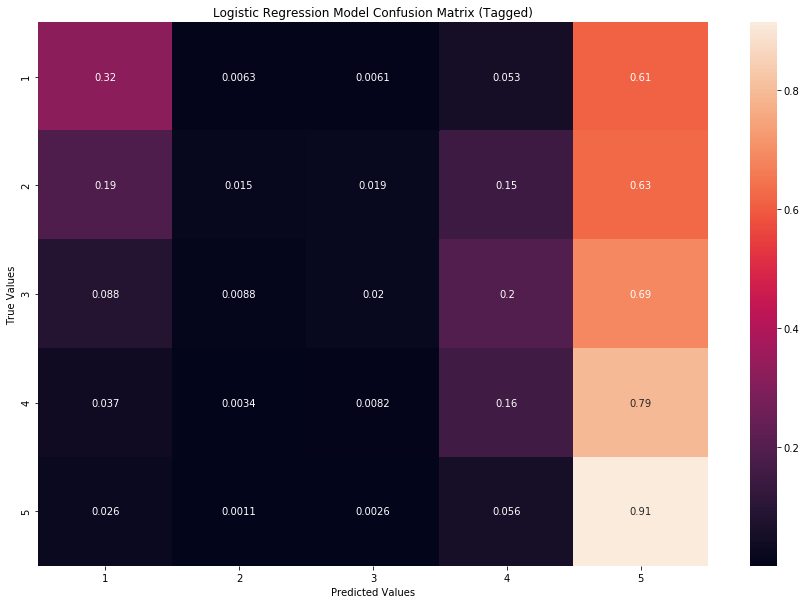

In [224]:
confusion = confusion_matrix(test_suby2, logregpos.predict(test_taggedX))
ax = sns.heatmap(confusion/confusion.sum(axis=1)[:, np.newaxis], 
            xticklabels=range(1,6), yticklabels=range(1,6),annot=True)
ax.set(xlabel='Predicted Values', ylabel='True Values')
ax.set_title('Logistic Regression Model Confusion Matrix (Tagged)');

## Bag of Words Models

- Frequency based models
- Many more features

In [7]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer('english')
subX =[' '.join([stemmer.stem(word) for word in text.split(' ')])for text in subX]
train_subX, test_subX, train_suby, test_suby = train_test_split(subX, suby, train_size = 0.8)

In [62]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

In [206]:
tvect = TfidfVectorizer(min_df=100, stop_words="english", ngram_range=(1,3)).fit(train_subX)

In [207]:
train_tvectX = tvect.transform(train_subX)
test_tvectX = tvect.transform(test_subX)

### Multinomial Naive Bayes Model

In [64]:
nbmodel = MultinomialNB()
nbmodel.fit(train_tvectX, train_suby)
nbmodel.score(test_tvectX, test_suby)

0.6253587243666495

In [114]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
nbconfusion = confusion_matrix(test_suby, nbmodel.predict(test_tvectX))

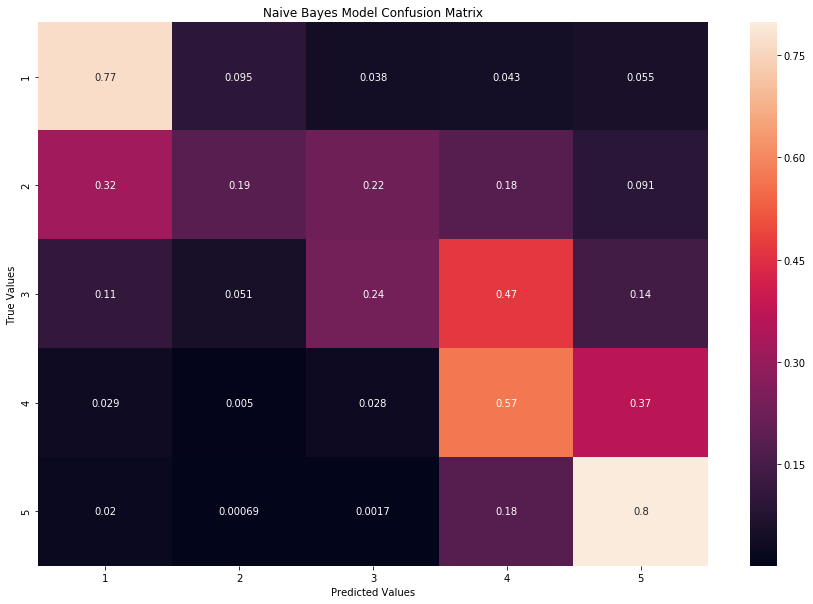

In [222]:
ax2 = sns.heatmap(nbconfusion/nbconfusion.sum(axis=1)[:, np.newaxis], 
            xticklabels=range(1,6), yticklabels=range(1,6),annot=True)
ax2.set(xlabel='Predicted Values', ylabel='True Values')
ax2.set_title('Naive Bayes Model Confusion Matrix');

### Logistic Regression Model

In [209]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(train_tvectX, train_suby)
logreg.score(test_tvectX, test_suby)

0.6641199612292605

In [210]:
logreg.score(train_tvectX, train_suby)

0.7126162895669609

In [220]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
confusion = confusion_matrix(test_suby, logreg.predict(test_tvectX))

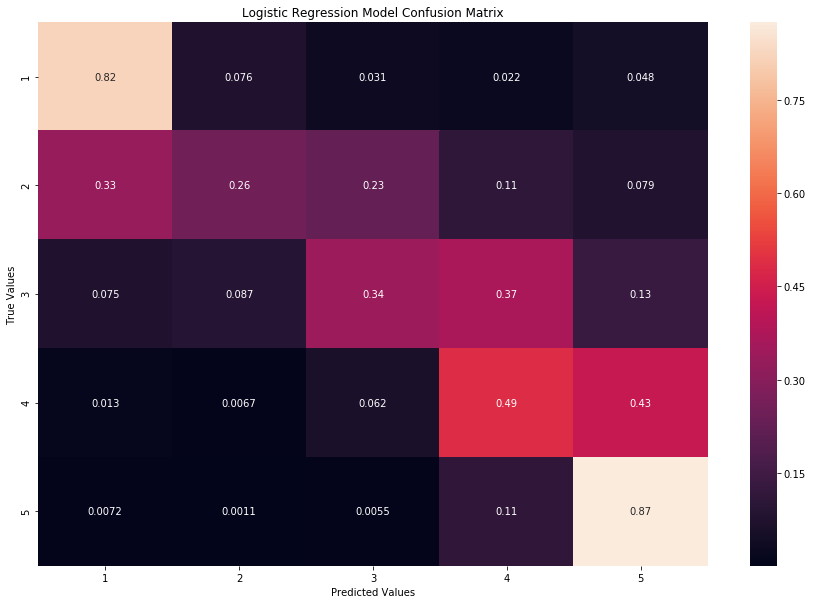

In [221]:
ax = sns.heatmap(confusion/confusion.sum(axis=1)[:, np.newaxis], 
            xticklabels=range(1,6), yticklabels=range(1,6),annot=True)
ax.set(xlabel='Predicted Values', ylabel='True Values')
ax.set_title('Logistic Regression Model Confusion Matrix');

In [5]:
import pickle
logreg = pickle.load(open('lrmodel.sav', 'rb'))
tvect = pickle.load(open('tvect.sav', 'rb'))

In [36]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.rcParams['figure.figsize'] = (10,7)

# Making Model-based Predictions

In [24]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer('english')
def testme(comment):
    review = [comment]
    review =[' '.join([stemmer.stem(word) for word in text.split(' ')])for text in review]
    minitest = tvect.transform(review)
    logreg.predict_proba(minitest)
    plt.bar([1,2,3,4,5],np.ravel(logreg.predict_proba(minitest)), color = '#f03b20')
    plt.xlabel('Stars')
    plt.ylabel('Probability')
    plt.ylim(0,1)
    plt.title('Star-Rating Probability')
    plt.grid()
    plt.show()

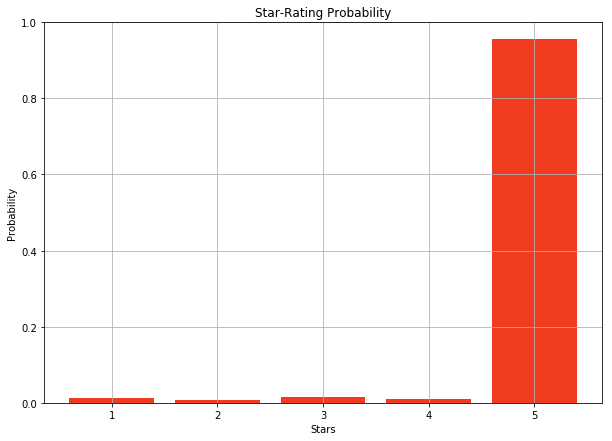

In [37]:
testme('This is the best restaurant I have ever been to.')

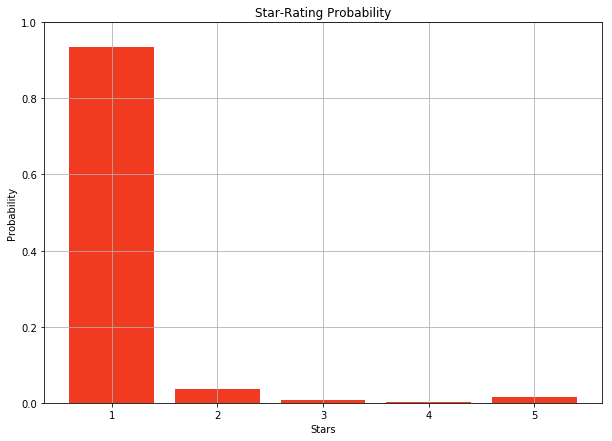

In [38]:
testme('The service at this store is absolutely awful. I will never come here again')

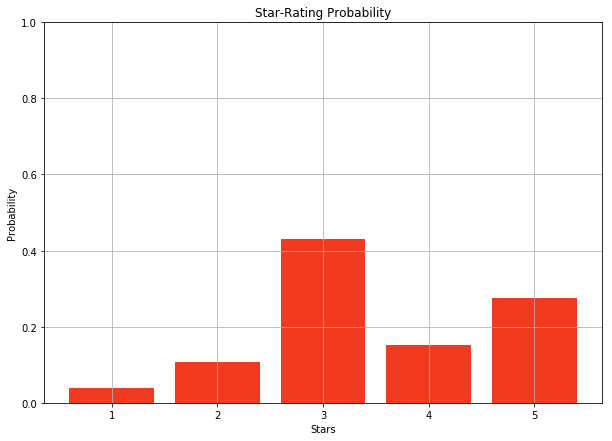

In [39]:
testme('The food was good, but there were too many people.')

# Further predictions

- Ensemble methods do not appear to work well with bag of words data.
- KNN, Decision Trees and Random Forest models all perform well below Naive Bayes models and Logistic Regression models
- Moving into neural networks, Convolutional Neural Networks are known to work well with text (and image) data.
